In [1]:
import re

import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [3]:
path = Path('Data/May2015_subset.fthr')

In [4]:
# df = pd.read_feather('Data/May2015_subset.fthr')
import feather
df = feather.read_dataframe(path)

In [5]:
df.head(2).T

,0,1
created_utc,1430438402,1430438411
ups,1,12
subreddit_id,t5_2qh22,t5_2qh22
link_id,t3_34gb0n,t3_34gfze
name,t1_cqug92d,t1_cqug99n
score_hidden,0,0
author_flair_css_class,None,MAL
author_flair_text,None,http://myanimelist.net/animelist/Link_of_Hyrule
subreddit,anime,anime
id,cqug92d,cqug99n


In [6]:
df.subreddit.value_counts()

leagueoflegends      1223184
funny                 745916
news                  548287
todayilearned         519910
worldnews             490354
movies                376601
gaming                361265
politics              244927
explainlikeimfive     223148
anime                 221118
gameofthrones         191006
motorcycles            89721
science                89413
conspiracy             78349
tf2                    76549
sex                    74912
guns                   61234
comicbooks             60303
pokemon                59730
food                   55231
starcraft              53797
askscience             53017
mylittlepony           44119
space                  42726
skyrim                 40568
circlejerk             30134
facepalm               22562
community              20635
harrypotter            19998
progresspics           13385
drunk                  13027
startrek               12275
thewalkingdead         10357
offbeat                10035
lifehacks     

In [7]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']

In [8]:
df = df[df.subreddit.isin(subreddit_list)]

In [9]:
df.shape

(1372864, 22)

In [10]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')
df['link_id'] = df.link_id.astype('category')

df.drop(['archived', 'retrieved_on', 'id',
         'author_flair_css_class', 'author_flair_text',
         'removal_reason'], axis=1, inplace=True)

In [11]:
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

In [12]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'score_hidden',
       'subreddit', 'gilded', 'downs', 'author', 'score', 'body',
       'distinguished', 'edited', 'controversiality', 'parent_id'],
      dtype='object')

In [13]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.7322739034038498 GB'

In [14]:
assert len(df.subreddit_id.unique()) == len(df.subreddit.unique())

In [15]:
df.subreddit.value_counts()

worldnews    490354
movies       376601
gaming       361265
science       89413
food          55231
Name: subreddit, dtype: int64

In [16]:
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [17]:
df_first_comment = df[['link_id', 'time']].groupby(by=['link_id']).min()

In [18]:
df_first_comment.shape

(46546, 1)

In [19]:
df_first_comment_dict = df_first_comment.to_dict('index')

In [20]:
def time_lapse(x):
    return df_first_comment_dict[x]['time']

In [21]:
df['time_lapse'] = df.time - df.link_id.apply(time_lapse)

In [22]:
df.time_lapse = df.time_lapse.apply(lambda x: x.total_seconds())

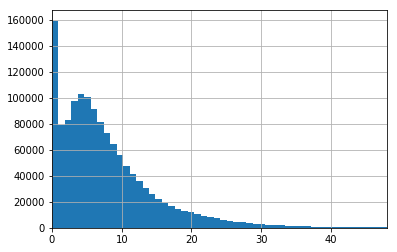

In [23]:
(df.time_lapse / (60*60)).hist(bins=800).set_xlim((0, 48));

In [24]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

In [25]:
comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

In [26]:
len(comment_to_parent_dict)

1372864

In [27]:
def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return np.nan
        counter += 1

In [28]:
df['depth'] = df['name'].apply(get_depth)

In [29]:
df.depth.isna().sum() / float(df.shape[0])

0.01057424479045266

In [30]:
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))

In [31]:
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

In [32]:
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

In [33]:
def get_domains(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url).netloc.split('.')[-2] for url in urls]
    except:
        return []
    return domain_names

In [34]:
df['linked_urls'] = df.body.apply(lambda x: get_domains(x))

In [35]:
def remove_urls(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)

In [36]:
df['body'] = df.body.apply(lambda x: remove_urls(x))

In [37]:
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

In [38]:
all_linked_sr = []
for l in df.linked_sr.values:
    all_linked_sr += l
len(all_linked_sr)

35356

In [39]:
top_sr_links = Counter(all_linked_sr)
top_sr_links.most_common(20)

[('worldnews', 4946),
 ('worldnews)', 2796),
 ('worldnews.', 2489),
 ('help', 2387),
 ('worldnews](http:', 2387),
 ('food),', 1594),
 ('gaming', 1435),
 ('food)', 1283),
 ('movies', 1225),
 ('science', 1044),
 ('movies)', 467),
 ('EverythingScience.', 459),
 ('AutoModerator', 452),
 ('conspiracy', 241),
 ('science.', 206),
 ('movies.', 191),
 ('Movies', 176),
 ('food', 174),
 ('nottheonion', 156),
 ('science)', 136)]

Should not probably use the actual names.

In [40]:
all_linked_urls = []
for l in df.linked_urls.values:
    all_linked_urls += l
len(all_linked_urls)

106993

In [41]:
top_url_links = Counter(all_linked_urls)
top_url_links.most_common(15)

[('reddit', 20232),
 ('youtube', 14216),
 ('wikipedia', 11078),
 ('imgur', 8154),
 ('youtu', 3616),
 ('redditblog', 2393),
 ('imdb', 2132),
 ('co', 1811),
 ('theguardian', 823),
 ('google', 733),
 ('github', 606),
 ('wordpress', 556),
 ('nytimes', 508),
 ('twitter', 432),
 ('amazon', 425)]

In [42]:
allowed_urls = [i[0] for i in top_url_links.most_common(15)]

In [43]:
def remove_urls(x):
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

In [44]:
df['a_linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))

Small i doesn't work for subjectivity

In [45]:
df['subjectivity'] = df['body'].str.count('I ')

In [46]:
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [47]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.9774239446984363 GB'

To check if the comment is quotes another comment.

In [48]:
# if the comment is qouted
df['is_quoted'] = df.body.str.contains('&gt;')

In [49]:
df['no_quoted'] = df.body.str.count('&gt;')

In [50]:
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

In [51]:
def get_parent_score(x):
    try:
        return comment_to_score[x]
    except:
        return 0

In [52]:
df['parent_score'] = df.parent_id.apply(lambda x: get_parent_score(x))

In [53]:
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

In [54]:
def get_time_since_parent(pi):
    try:
        return comment_to_time[pi]
    except:
        return np.nan

In [55]:
df['time_since_parent'] = df.parent_id.apply(get_time_since_parent)

In [56]:
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time

In [57]:
df.time_since_parent = df.time - df.time_since_parent

In [58]:
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [59]:
df.head(3).T

,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
subreddit,food,food,food
gilded,0,0,0
downs,0,0,0
author,FightWithTools,BlakShuck,westhest


## Sentiment Based Features

This cell will take a couple of minutes to run.
-  `senti_neg`: negative score of comment
- `senti_neu`: neutral score of comment
- `senti_pos`: positive score of comment
- `senti_comp`: compound score of comment

In [60]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# sentiment analyzer
analyser = SentimentIntensityAnalyzer() # http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

# get sentiment scores 
def get_sentiment(x):
    return analyser.polarity_scores(x)

# get sentiment scores from 'body' column of dataframe
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

# to apply operation in parallel
num_partitions = 100
num_cores = 4
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# add a column for each score to our data
sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)
sentiment.drop(['body'], axis=1, inplace=True)
df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])
del sentiment

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [61]:
print(df.shape)
df.head(3).T

(1372864, 34)


,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
subreddit,food,food,food
gilded,0,0,0
downs,0,0,0
author,FightWithTools,BlakShuck,westhest


In [62]:
# save new data
df.to_pickle('Data/working_sub.pkl')

## Comment Length Based Features

- `word_count`: number of words in comment

In [63]:
df = pd.read_pickle('Data/working_sub.pkl')

In [64]:
# get number of words in comment
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count
del word_counts

In [65]:
print(df.shape)
df.head(3).T

(1372864, 35)


,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
subreddit,food,food,food
gilded,0,0,0
downs,0,0,0
author,FightWithTools,BlakShuck,westhest


In [66]:
# save new data
df.to_pickle('Data/working_sub.pkl')

## Comment2Vec Based Features

- `doc2vec`: centroid of 50 dimensional word embeddings
- `cos_angle`: cosine similarity between comment and its parent

In [67]:
df = pd.read_pickle('Data/working_sub.pkl')

In [68]:
import string
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector
    return glove

def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]
    return terms

def doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)

    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

gloves = load_glove('Data/glove.6B.50d.txt')

def wrapper_get_centroid(df):
    df['doc2vec'] = df['body'].apply(lambda x: doc2vec(x, gloves))
    return df

# get centroid of each comment
doc2vec_vals = parallelize_dataframe(df['body'].to_frame(), wrapper_get_centroid)
doc2vec_vals = doc2vec_vals.doc2vec.values
df['doc2vec'] = doc2vec_vals

comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_parent = pd_to_dict(df[['name', 'parent_id']],
                                index='name', column='parent_id')

def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        return None
    child = doc2vec(child, gloves)
    parent = doc2vec(parent, gloves)
    if child is None:
        return None
    if parent is None:
        return None
    return child.dot(parent)

def wrapper_get_cosine(df):
    df['cosine_angle'] = df['name'].apply(get_cosine_angle)
    return df

# get cosine angle between comment and its parent's comment centroid
cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)
df['cos_angle'] = cosine_angle.cosine_angle
del gloves
del doc2vec
del cosine_angle

In [69]:
print(df.shape)
df.head(3).T

(1372864, 37)


,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
subreddit,food,food,food
gilded,0,0,0
downs,0,0,0
author,FightWithTools,BlakShuck,westhest


In [70]:
# save new data
df.to_pickle('Data/working_sub.pkl')